In [ ]:
!pip install transformers datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-c

In [ ]:
!apt-get -y install fonts-noto

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core
  fonts-noto-extra fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra
  fonts-noto-unhinted
The following NEW packages will be installed:
  fonts-noto fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji
  fonts-noto-core fonts-noto-extra fonts-noto-mono fonts-noto-ui-core
  fonts-noto-ui-extra fonts-noto-unhinted
0 upgraded, 10 newly installed, 0 to remove and 30 not upgraded.
Need to get 317 MB of archives.
After this operation, 790 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto all 20201225-1build1 [16.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Final Year Project Work/Dataset/Train.csv', header=None, skiprows=1)
df = df[[2, 3]]
df.columns = ['text', 'label']

In [ ]:
# Mapping fine-grained emotions to 7 basic ones
label_mapping = {
    'மகிழ்ச்சி': 'மகிழ்ச்சி',
    'போற்றுதல்': 'மகிழ்ச்சி',
    'உற்சாகம்': 'மகிழ்ச்சி',
    'பெருமை': 'மகிழ்ச்சி',
    'நன்றியறிதல்': 'மகிழ்ச்சி',

    'சோகம்': 'சோகம்',
    'துக்கம்': 'சோகம்',
    'ஏமாற்றம்': 'சோகம்',
    'துயர் நீக்கம்': 'சோகம்',
    'சங்கடம்': 'சோகம்',

    'கோபம்': 'கோபம்',
    'எரிச்சல்': 'கோபம்',
    'கிண்டல்': 'கோபம்',

    'பயம்': 'பயம்',
    'பதட்டம்': 'பயம்',

    'அருவருப்பு': 'அருவருப்பு',
    'குற்றமுணர்ந்ததால் ஏற்படும் வருத்தம்': 'அருவருப்பு',

    'ஆச்சரியம்': 'ஆச்சரியம்',
    'ஆர்வம்': 'ஆச்சரியம்',

    'நடுநிலை': 'நடுநிலை',
    'ஒப்புதல்': 'நடுநிலை',
    'மறுப்பு': 'நடுநிலை',
    'உண்மையை உணர்தல்': 'நடுநிலை',
    'நம்பிக்கை': 'நடுநிலை',
    'எதிர்காலத்தைப் பற்றிய நம்பிக்கை': 'நடுநிலை',
    'அக்கறை': 'நடுநிலை',
    'அன்பு': 'நடுநிலை',
    'ஆசை': 'நடுநிலை',
    'எதிர்பார்ப்பு': 'நடுநிலை',
    'குழப்பம்': 'நடுநிலை',
    'கேளிக்கை': 'நடுநிலை'
}

In [ ]:
# Add new column with mapped basic emotion labels
df['basic_emotion'] = df['label'].map(label_mapping)

In [ ]:
# Drop rows where mapping failed (i.e., NaN values)
df = df.dropna(subset=['basic_emotion']).reset_index(drop=True)

In [ ]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['basic_emotion'])
label2id = {label: idx for idx, label in enumerate(le.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

In [ ]:
# 🔍 Print label to numeric mapping
print("Label to ID mapping:")
for label, idx in label2id.items():
    print(f"{label}: {idx}")

Label to ID mapping:
அருவருப்பு: 0
ஆச்சரியம்: 1
கோபம்: 2
சோகம்: 3
நடுநிலை: 4
பயம்: 5
மகிழ்ச்சி: 6


In [ ]:
import re

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002700-\U000027BF"  # dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
df['text'] = df['text'].apply(remove_emojis)

In [ ]:
df

,text,label,basic_emotion,label_encoded
0,எந்த ஒரு மிகப் பெரிய விஷயமாக இருந்தாலும் அதோட ...,ஒப்புதல்,நடுநிலை,4
1,ராணி தேனி எப்படி கண்டுபிடிக்கிறது,எதிர்பார்ப்பு,நடுநிலை,4
2,இன்னும் நிறைய கண்டு பிடிப்புகள் சொல்லவில்லை. ப...,நடுநிலை,நடுநிலை,4
3,100% உண்மை..... வாழ்த்துக்கள் உண்மையை உரக்க சொ...,உண்மையை உணர்தல்,நடுநிலை,4
4,இது உண்மையாக இருக்கட்டும்,ஒப்புதல்,நடுநிலை,4
...,...,...,...,...
30174,"இப்டியாவது இந்தியாவையும், பாகிஸ்தானையும் சேத்த...",ஆசை,நடுநிலை,4
30175,எங்கடா இருந்திங்க நீங்கலாம் இவளவு நாளா தமிழ் ந...,கிண்டல்,கோபம்,2
30176,சுஷில்ஹரி பள்ளியை பற்றி தகவல் வருகிறது அதையும்...,எதிர்பார்ப்பு,நடுநிலை,4
30177,அருமை... அங்குள்ள தற்போதைய நிலவரத்தை கூற முடிய...,எதிர்பார்ப்பு,நடுநிலை,4


<ipython-input-15-bf5e099c7b4a>:16: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Tamil.
  plt.tight_layout()
<ipython-input-15-bf5e099c7b4a>:16: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Tamil.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Tamil.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Tamil.
  fig.canvas.print_figure(bytes_io, **kw)


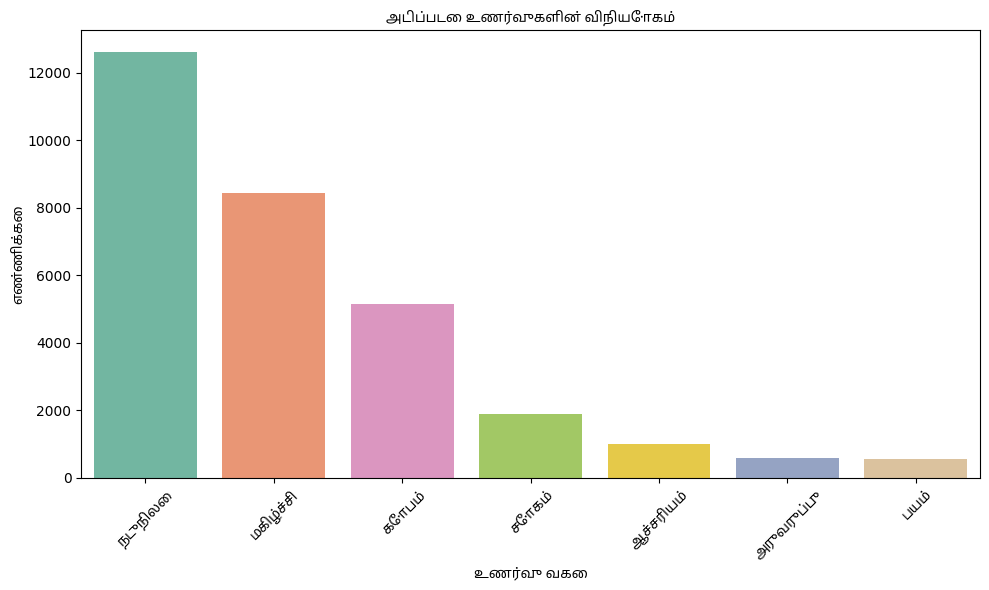

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns # Import the seaborn library

# Load Noto Sans Tamil font
font_path = '/usr/share/fonts/truetype/noto/NotoSansTamil-Regular.ttf'
tamil_font = fm.FontProperties(fname=font_path)

# Plot with Tamil font
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='basic_emotion', hue='basic_emotion', order=df['basic_emotion'].value_counts().index, palette='Set2', legend=False)
plt.title("அடிப்படை உணர்வுகளின் விநியோகம்", fontproperties=tamil_font)
plt.xlabel("உணர்வு வகை", fontproperties=tamil_font)
plt.ylabel("எண்ணிக்கை", fontproperties=tamil_font)
plt.xticks(rotation=45, fontproperties=tamil_font)
plt.tight_layout()
plt.show()

In [ ]:
hf_dataset = Dataset.from_pandas(df[['text', 'label_encoded']])
hf_dataset = hf_dataset.train_test_split(test_size=0.2)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("l3cube-pune/tamil-bert")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

tokenized_dataset = hf_dataset.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label_encoded", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/24143 [00:00<?, ? examples/s]

Map:   0%|          | 0/6036 [00:00<?, ? examples/s]

In [ ]:
# Step 7: Load Model for Sequence Classification
model = AutoModelForSequenceClassification.from_pretrained("l3cube-pune/tamil-bert", num_labels=len(label2id), id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/tamil-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ✅ Step 8: Set Training Arguments
training_args = TrainingArguments(
    output_dir="/content/tamil-bert-emotion",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    # evaluation_strategy="epoch",
    # save_strategy="epoch",
    logging_dir="/content/logs",
    logging_steps=10,
    # load_best_model_at_end=True,
    # metric_for_best_model="accuracy",
    report_to="none"  # 🔥 Disable W&B, TensorBoard, etc.
)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-23-c013178cfa17>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss
10,1.931800
20,1.889000
30,1.837800
40,1.780000
50,1.768100
60,1.711300
70,1.644900
80,1.598100
90,1.602400
100,1.530600


TrainOutput(global_step=9054, training_loss=1.153780333116825, metrics={'train_runtime': 2725.9356, 'train_samples_per_second': 26.57, 'train_steps_per_second': 3.321, 'total_flos': 4764431537107200.0, 'train_loss': 1.153780333116825, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 1.2749000787734985,
 'eval_accuracy': 0.5795228628230616,
 'eval_f1': 0.25733050375553074,
 'eval_runtime': 43.9733,
 'eval_samples_per_second': 137.265,
 'eval_steps_per_second': 17.17,
 'epoch': 3.0}

In [ ]:
trainer.save_model("/content/drive/MyDrive/Final Year Project Work/Model Weights/tamil-bert-emotion-model")

In [ ]:
# ✅ Step 14: Predict on New Sample
text = "இங்கு ஒரே சிறுநீர் துர்நாற்றமா இருக்கு"

# Ensure inputs and model are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
outputs = model(**inputs)
pred = torch.argmax(outputs.logits, dim=1).item()

print("Predicted Emotion:", id2label[pred])

Predicted Emotion: கோபம்


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "/content/drive/MyDrive/Final Year Project Work/Model Weights/tamil-bert-emotion-model"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

text = "இன்று எனக்கு மிகவும் கோபமாக இருக்கிறது"
result = classifier(text)

print(result)

Device set to use cuda:0


[{'label': 'கோபம்', 'score': 0.24090470373630524}]
